In [50]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [64]:
def get_parent_fingerprints(csv): # Input csv requires the column parent_smiles
    dataset = pd.read_csv(csv)

    parent_smiles = np.array(dataset['parent_smiles'].tolist())
    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]

    # Convert ExplicitBitVect to numpy arrays
    parent_fps_array = [np.array(fp) for fp in parent_fps]

    dataset['fps'] = parent_fps_array

    return dataset

def get_child_fingerprints(csv): # Input csv requires the column parent_smiles
    dataset = pd.read_csv(csv)

    child_smiles = np.array(dataset['child_smiles'].tolist())
    child_mol = [Chem.MolFromSmiles(x) for x in child_smiles]
    child_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in child_mol]

    # Convert ExplicitBitVect to numpy arrays
    child_fps_array = [np.array(fp) for fp in child_fps]

    dataset['fps'] = child_fps_array

    return dataset

def do_PCA(dataset, n_pca_components=1024):
    fp_list = np.array(dataset['fps'].tolist())

    # Perform PCA
    pca = PCA(n_components=n_pca_components)
    crds = pca.fit_transform(fp_list)

    #Calculate explained variance
    explained_variance = pca.explained_variance_ratio_

    # Get principal component vectors 
    principal_components = pca.components_

    return crds, explained_variance, principal_components

def PC1_files(dataset, crds):
    
    PC1 = crds[:,0]

    df_pc1low = dataset[PC1 < 0]
    df_pc1high = dataset[PC1 > 2]

    df_pc1low.to_csv('/projects/cc/se_users/carlsson_ksmq649/MasterThesis/data_analysis/pc1_less_than_0.csv', index=False)
    df_pc1high.to_csv('/projects/cc/se_users/carlsson_ksmq649/MasterThesis/data_analysis/pc1_greater_than_2.csv', index=False)

def get_fingerprint_comparison(csv):
    dataset = pd.read_csv(csv)

    parent_smiles = np.array(dataset['parent_smiles'].tolist())
    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]
    parent_fps_array = np.array([np.array(fp) for fp in parent_fps])

    child_smiles = np.array(dataset['child_smiles'].tolist())
    child_mol = [Chem.MolFromSmiles(x) for x in child_smiles]
    child_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in child_mol]
    child_fps_array = np.array([np.array(fp) for fp in child_fps])

    comparison_fps_array = parent_fps_array - child_fps_array

    dataset['fps'] = comparison_fps_array.tolist()

    return dataset



In [52]:
def plot_pca(crds, explained_variance, dataset):
    source_column = np.array(dataset['source'].tolist())
    crds_array = np.array(crds)

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot DrugBank data
    drugbank_mask = source_column == 'DrugBank'
    plt.scatter(crds_array[drugbank_mask, 0], crds_array[drugbank_mask, 1],  
                color='orange', marker='^', label='DrugBank')

    # Plot MetXBio data
    metxbio_mask = source_column == 'MetXBioDB'
    plt.scatter(crds_array[metxbio_mask, 0], crds_array[metxbio_mask, 1],  
                color='purple', marker='o', label='MetXBio')

    plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% variance)')
    plt.title('PCA of DrugBank and MetXBio Molecules - Morgan Fingerprints')
    plt.legend()
    plt.grid(True)
    plt.show()

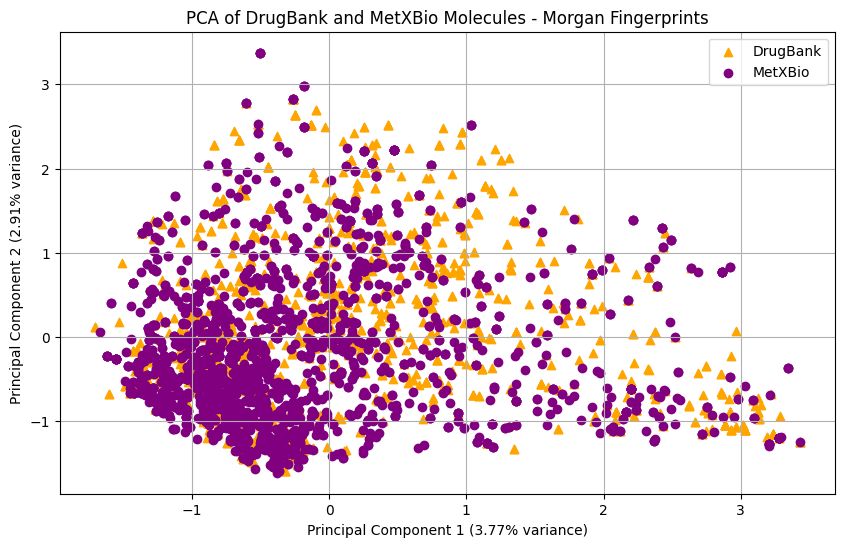

In [53]:
dataset = get_parent_fingerprints('/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/combined_smiles.csv')
crds, explained_variance, principal_components = do_PCA(dataset, 1024)
plot_pca(crds, explained_variance, dataset)


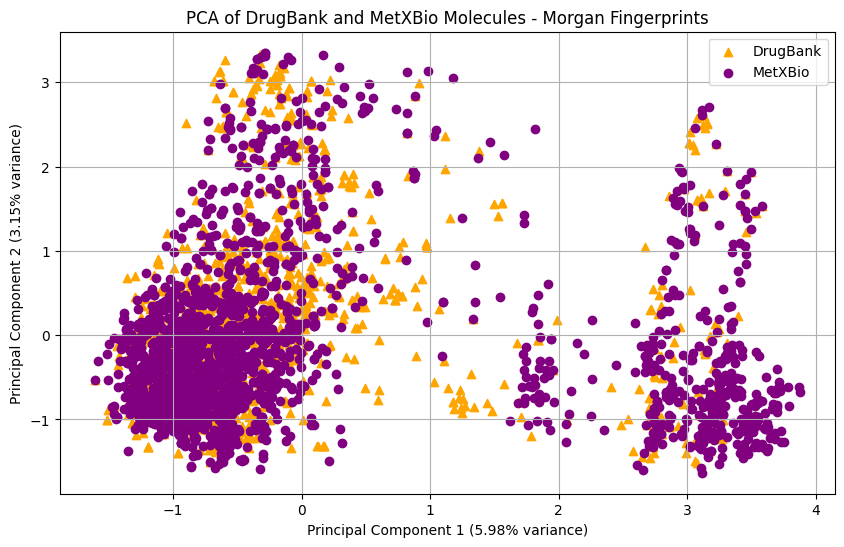

In [56]:
dataset = get_child_fingerprints('/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/combined_smiles.csv')
crds, explained_variance, principal_components = do_PCA(dataset, 1024)
plot_pca(crds, explained_variance, dataset)

PC1_files(dataset, crds)

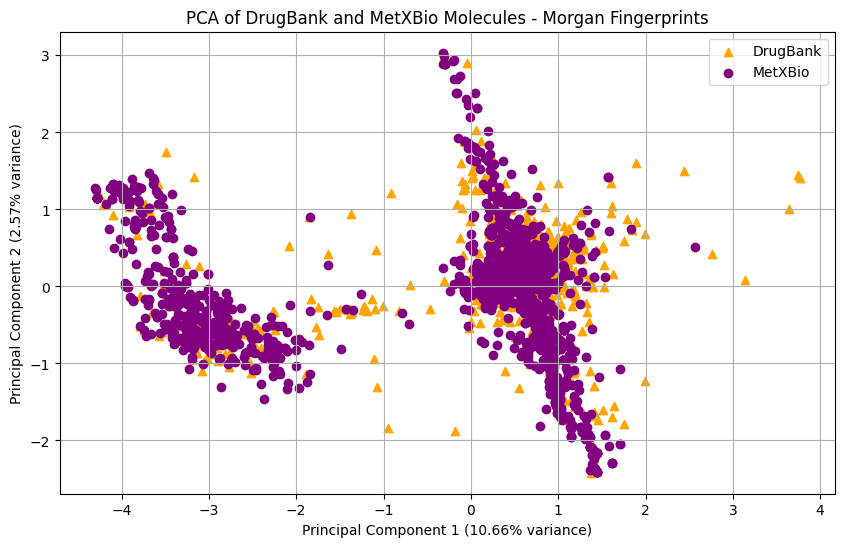

In [66]:
dataset = get_fingerprint_comparison('/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/combined_smiles.csv')
crds, explained_variance, principal_components = do_PCA(dataset)
plot_pca(crds, explained_variance, dataset)